<a href="https://colab.research.google.com/github/katiabarros/SQL/blob/main/Audio_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_io pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 36.3 MB/s eta 0:00:00


In [ ]:
import tensorflow_datasets as tfds

(dataset_train_original, dataset_validate_original), info = tfds.load(
    "spoken_digit",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

In [ ]:
info

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='/root/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
 

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_io as tfio
import pydub
import matplotlib.pyplot as plt
import librosa
from IPython.display import display, Audio

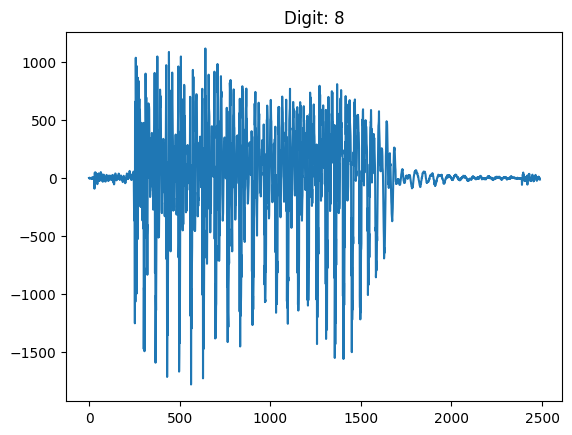

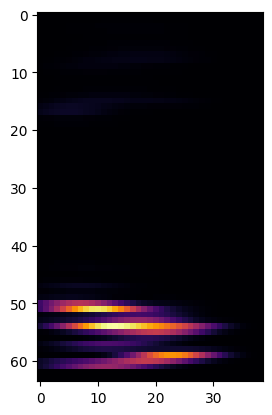

In [ ]:
for audio, label in dataset_train_original.shuffle(1000).take(1):
  audio = audio.numpy().astype(np.float32)

  plt.plot(audio)
  plt.title(f"Digit: {label}")
  
  plt.show()

  display(Audio(audio, rate=8000))
  mel = librosa.feature.melspectrogram(
      y=audio,
      n_mels=64,
      hop_length=64,
      sr=8000
  )
  plt.imshow(mel[::-1, :], cmap="inferno")

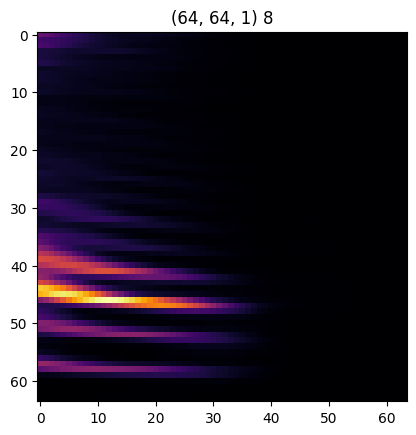

In [ ]:
def preprocess(audio, label):
  audio = tf.cast(audio, tf.float32) / 32768.0

  #Normalized mel spectrogram.
  spectrogram = tfio.audio.spectrogram(
      audio, nfft=1024, window=1024, stride=64
  )

  spectrogram = tfio.audio.melscale(
      spectrogram, rate=8000, mels=64, fmin=20, fmax=2000
  )

  spectrogram /= tf.math.reduce_max(spectrogram)  # Normalization
  
  spectrogram = tf.expand_dims(spectrogram, axis=-1)  #Go 3D

  spectrogram = tf.image.resize(spectrogram, (64, 64))  # Resize the image

  spectrogram = tf.transpose(spectrogram, perm=(1, 0, 2)) # Transposing width and height. For Tristan's happiness. 

  spectrogram = spectrogram[::-1, :, :]   #Flip upside down. For Tristan again. 

  return spectrogram, label

dataset = dataset_train_original.map(lambda x, y: preprocess(x,y))

for x, y in dataset.shuffle(1000).take(1):
  plt.imshow(x, cmap="inferno")
  plt.title(f"{x.shape} {y}")
  #print(y)

In [ ]:
dataset_train = dataset_train_original.map(lambda x, y: preprocess(x,y))
dataset_train = dataset_train.cache() 
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(32)

dataset_validate = dataset_validate_original.map(lambda x, y: preprocess(x,y)) 
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(32)

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(
    4, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 1)
))
model.add(tf.keras.layers.AveragePooling2D((2,2)))

model.add(tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(8, (3, 3), padding="same", activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(tf.keras.layers.AveragePooling2D((2, 2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

model.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(
    dataset_train, 
    epochs=50,
    validation_data=dataset_validate
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 4)         40        
                                                                 
 average_pooling2d_11 (Avera  (None, 32, 32, 4)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 8)         296       
                                                                 
 average_pooling2d_12 (Avera  (None, 16, 16, 8)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 8)         584       
                                                                 
 average_pooling2d_13 (Avera  (None, 8, 8, 8)         

In [ ]:
def plot_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()

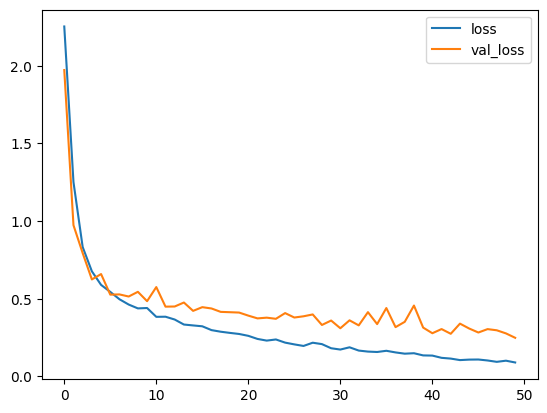

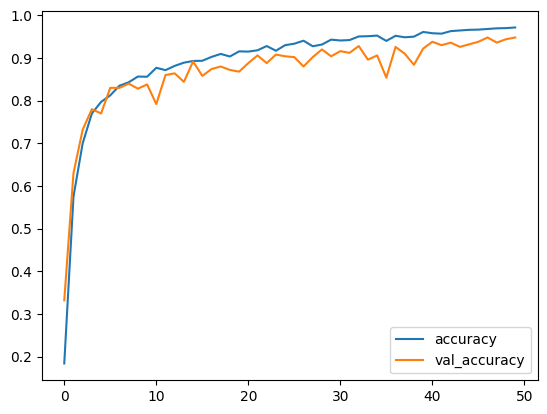

In [ ]:
plot_history(history.history)